# Deep Learned Representations

In the previous notebooks, we manually constructed various representations by employing a number of feature engineering techniques designed for working with acoustic data. In this notebook, we'll start with a conventional spectrogram-based approach, but we will feed these inputs into a generative network and proceed to extract features from the deep-learned latent space.

For this notebook, we will focus on macauque call data, available in the [ESP Library](https://github.com/earthspecies/library).

We will be employing a generative adversarial interpolative autoencoder (GAIA) architecure. The following code has been adapted and modified from [Tim Sainburg's AVGN GitHub repo](https://github.com/timsainb/avgn_paper).

# Imports, Constants, and GPU

We'll begin with some imports and some definitions of constants that we will make use of later in the notebook. Also, we'll test our GPU availability, since training the GAIA can take a substantial amount of time, especially if GPU is not enabled.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from fastai2.vision.all import *

import librosa
import soundfile as sf
from scipy import interpolate
import scipy.signal
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow_probability.python.distributions import Chi2

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

import pathlib
from IPython.display import Audio
import functools
import tqdm
import time
from IPython import display

import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [10]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
with tf.device('/GPU:0'):
    print('Running on GPU')
    gpu_test=np.array([1])
    tf_dataset_test = tf.data.Dataset.from_tensor_slices(gpu_test)

Running on GPU


In [12]:
SR = 24414
NFFT = 1024
HOP_LENGTH = None
WINDOW = scipy.signal.hanning
FMAX = 7500
DB_TH = 1e-4
RES = 128
BATCH_SIZE = 16
BUFFER_SIZE = 6000
LATENT_DIM = 128
EPOCHS = 25
MAX = 1
MIN = 0
DIMS = (RES,RES,1)
D_PROP_XG = 0.9
G_PROP_INTERP = 0.9
URL = 'https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip'

# Preparing the Data

Now we are ready to go! We'll start off by downloading the macaque data and visualizing the raw waveforms we are working with. This dataset consists of macaque coo calls generated by eight different individuals. Our aim will be to classify the call according to the appropriate vocalizing animal. We begin by creating a class to load our data.

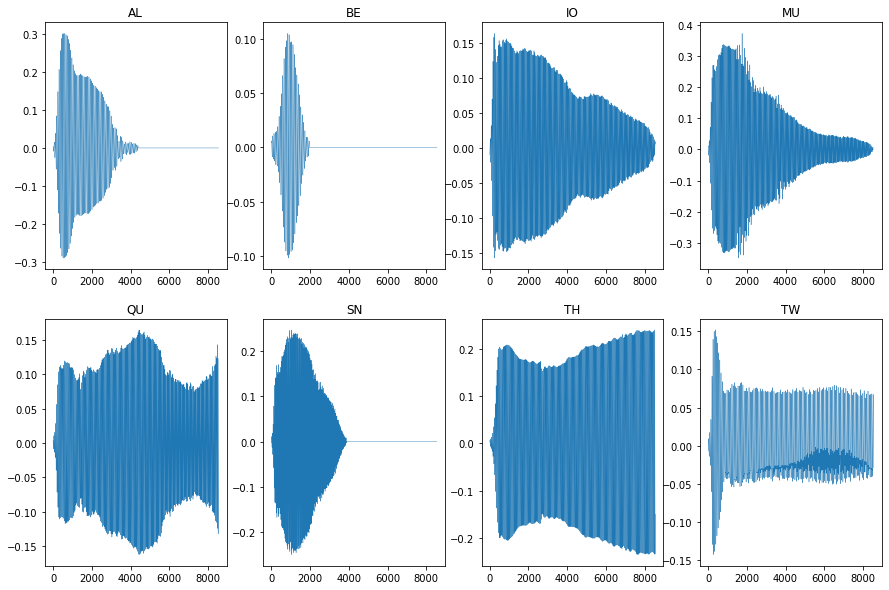

In [13]:
class LoadData(object):
    
    def __init__(self, url=URL):
        self.url = url
        
    def construct_dataframe(self):
        path = untar_data(self.url)
        wav_files = get_files(path)

        wfs = []
        labels = []
        wavs = []

        for wav in wav_files:
            call_code = re.split('/', str(wav))[-2]
            wf, _ = sf.read(wav)

            wfs.append(wf)
            labels.append(call_code)
            wavs.append(wav)

        call_dict = {l: i for i, l in enumerate(np.unique(labels))}
        call_category = [call_dict[i] for i in labels]
        data_df = pd.DataFrame({'Waveform':wfs, 'Path': wavs, 'Label': labels, 'Category': call_category})
        
        return data_df
    
    def fixed_dataframe(self):
        
        dataframe = self.construct_dataframe()
        
        mean_dur = self.get_mean_duration(dataframe)
        paths = dataframe.Path.values
        labels = dataframe.Label.values
        categories = dataframe.Category.values
        waveforms = dataframe.Waveform.values

        xs = []
        for wf in waveforms:
            x = librosa.util.fix_length(wf, mean_dur)
            xs.append(x)
        fixed_df = pd.DataFrame({'Waveform':xs, 'Path': paths, 'Label':labels, 'Category':categories})    
        return fixed_df
    
    def balanced_dataframe(self):
    
        dataframe = self.fixed_dataframe()
        balanced_df = dataframe.groupby('Category')
        balanced_df = balanced_df.apply(lambda x: x.sample(balanced_df.size().min()).reset_index(drop=True))

        return balanced_df
    
    def visualize_classes(self, dataframe, group='Label'):
        df = dataframe.groupby(group).apply(lambda x: x.sample(1))
        df = df.reset_index(drop=True)

        fig, axes = plt.subplots(2,4, figsize=(15,10))
        for i, ax in enumerate(axes.flatten()):
            ax.plot(df.Waveform.iloc[i], linewidth=0.4)
            ax.set_title(df.Label.iloc[i])
        plt.show()
    
    @staticmethod
    def get_mean_duration(dataframe):
        waveforms = dataframe.Waveform.values
        durs = []
        for wf in waveforms:
            durs.append(wf.shape[0])
        mean_dur = int(np.mean(durs))
        return mean_dur
    
loader = LoadData()
data_df = loader.balanced_dataframe()
mean_dur = loader.get_mean_duration(data_df)
loader.visualize_classes(data_df)

As we can see, the different coo calls vary in their duration, so we've opted to use the ``librosa.util.fix_length`` method to fix the lengths of the signals. With this in mind, we'll define a few additional constants.

In [14]:
MEAN_DURATION = mean_dur
WINDOW_WIDTH = MEAN_DURATION

The last step in this data labeling preprocessing phase involves constructing the training and testing datasets. This is accomplished as follows:

In [15]:
X_numpy = np.zeros((len(data_df), MEAN_DURATION), dtype=np.float32)
for i, wf in enumerate(data_df.Waveform.values):
    X_numpy[i, :] = wf
Y=data_df.Category.values

X_train, X_test, Y_train, Y_test = train_test_split(X_numpy, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2995, 8549), (749, 8549), (2995,), (749,))

In [16]:
with tf.device('/GPU:0') :   
    gaia_train_ds = tf.data.Dataset.from_tensor_slices(X_train)
    gaia_train_ds = gaia_train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)
    gaia_train_ds = gaia_train_ds.prefetch(-1)

In [17]:
N_TRAIN_BATCHES =int(X_train.shape[0]/BATCH_SIZE)

In [12]:
example_data = next(iter(gaia_train_ds))

Here, note that we have a few different datasets since we'll have to train the initial GAIA model in addition to the downstream classifier models. The ``example_data`` will be used to visualize the reconstructions during training.

## Constructing a Spectrogram Model

Now that we've loaded the data, let's construct a spectrogram builder that allows us to take in raw waveforms and output spectrograms. We'll achieve this by defining custom layers that we can include in our networks down the road. We'll also include a ``MinMaxScaler`` layer.

In [18]:
class SpecGram(tf.keras.layers.Layer):
    def __init__(self, name='spectrogram', **kwargs):
        super(SpecGram, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.spectrogram_representation(input_)

    @tf.function
    def spectrogram_representation(self, x):

        def construct_spectrogram(signal, sr=SR, nfft=NFFT, hoplength=HOP_LENGTH, win=WINDOW, db_th=DB_TH):
            if hoplength is None:
                hoplength = nfft//16

            _, _, spec = librosa.reassigned_spectrogram(y=signal, sr=sr, n_fft=nfft, hop_length=hoplength, window=win)
            spec_db = librosa.power_to_db(spec, amin=db_th)
            f_bins = librosa.core.fft_frequencies(sr=sr, n_fft=nfft)
            t_bins = np.linspace(0, len(signal)/sr, spec[0].shape[0])
            return t_bins,f_bins, spec_db

        def interp_spectrogram(spec, t, f, res=RES, fmax=FMAX):
            if fmax is None:
                fmax = np.max(f)

            interp_fx = interpolate.interp2d(t, f, spec, kind='cubic')
            ts_interp = np.linspace(np.min(t), np.max(t), res)
            freqs_interp = np.linspace(np.min(f), fmax, res)
            spec_interp = interp_fx(ts_interp, freqs_interp)
            return spec_interp, freqs_interp, ts_interp

        def generate_representation(waveform, sr=SR, nfft=NFFT, db_th=DB_TH, win=WINDOW, res=RES, fmax=FMAX):
            batch_size= waveform.shape[0]
            reps = np.zeros((batch_size, res, res))
            for n in range(batch_size):
                t, f, Sxx = construct_spectrogram(waveform[n,:], sr=sr, nfft=nfft, win=win, db_th=db_th)
                rep, _, _ = interp_spectrogram(Sxx, t, f, res, fmax)
                reps[n, :, :] = rep
            return reps.astype('float32')

        @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
        def tf_rep(input_):
            y = tf.numpy_function(generate_representation, [input_], tf.float32)
            return y

        x = tf.cast(x, tf.float32)
        result = (tf_rep(x))
        return tf.keras.backend.reshape(result, (-1, RES, RES))

    def get_config(self):
        config = super(SpecGram, self).get_config()
        return config

    def vis_rep(self, X_examples, Y_examples):
        N_examples = X_examples.shape[0]

        def is_sqrt(x):
            sq = np.sqrt(x)
            return (sq - np.floor(sq))==0

        if ~is_sqrt(N_examples):
            raise ValueError('Choose a perfect square number of examples')
        else:
            plot_dim = int(np.sqrt(N_examples))

        reps = self.spectrogram_representation(X_examples)
        fig, axes = plt.subplots(plot_dim, plot_dim, figsize=(15, 10))
        axs = axes.flatten()
        for n in range(N_examples):
            axs[n].imshow(reps[n, :, :].numpy(), cmap='magma')
            axs[n].invert_yaxis()
            axs[n].set_xticks([])
            axs[n].set_yticks([])
            axs[n].set_title(f'Class {Y_examples[n]}')

In [19]:
class MinMaxScaler(tf.keras.layers.Layer):
    def __init__(self, name='min_max_scaler', **kwargs):
        super(MinMaxScaler, self).__init__(name=name, **kwargs)

    def call(self, input_):
        return self.min_max_scaler(input_)

    @tf.function
    def min_max_scaler(self, x):
        batch, height, width = x.shape
        x = tf.cast(x, tf.float32)

        _min = tf.math.reduce_min(x, axis=2, keepdims=True, name=None)
        _min = tf.math.reduce_min(_min, axis=1, keepdims=True, name=None)

        _max = tf.math.reduce_max(x, axis=2, keepdims=True, name=None)
        _max = tf.math.reduce_max(_max, axis=1, keepdims=True, name=None)

        x_norm = (MAX - MIN) * (x - _min) / (_max - _min) + MIN
        return x_norm

    def get_config(self):
        config = super(MinMaxScaler, self).get_config()
        return config

In [20]:
class SpecBuilder(tf.keras.Model):

    def __init__(self):
        super(SpecBuilder, self).__init__()
        self.builder = self.build_spec_model()

    def build_spec_model(self):
        spec_inputs = tf.keras.Input(shape=(WINDOW_WIDTH,))
        x = SpecGram()(spec_inputs)
        x = MinMaxScaler()(x)
        outputs = tf.keras.layers.Reshape((RES, RES, 1), input_shape=(RES, RES))(x)

        spec_model = tf.keras.Model(spec_inputs, outputs, name='spec_builder')
        return spec_model

    def call(self, x):
        return self.builder(x)

Let's see how this works:

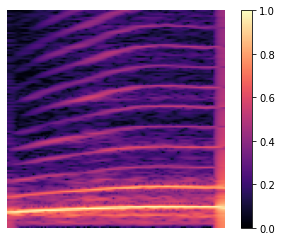

In [21]:
spec_builder = SpecBuilder()
specs = spec_builder(X_train[0:1])
plt.imshow(specs.numpy()[0, :, :, 0], cmap='magma')
plt.gca().invert_yaxis()
plt.axis('off')
plt.colorbar()
plt.show()

Looks good! Note that we can also instantiate a ``SpecGram`` object in order to visualize several examples:

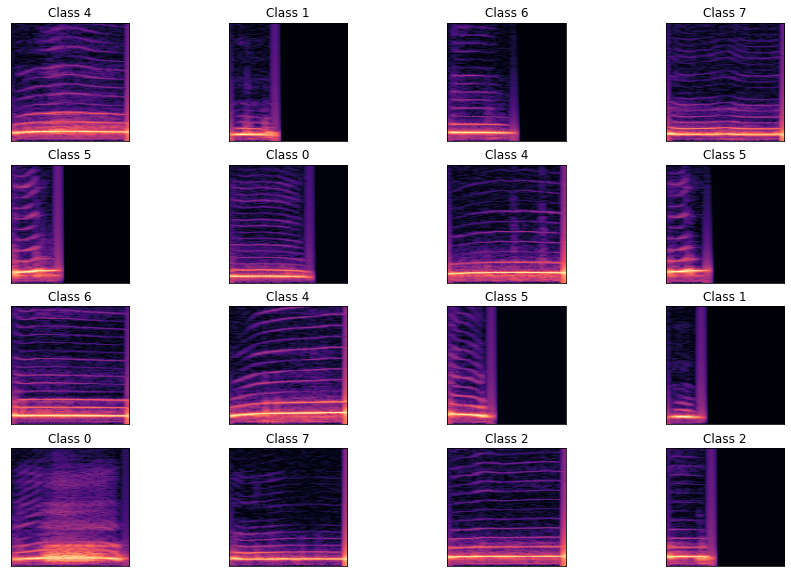

In [17]:
SpecGram().vis_rep(X_train[0:16], Y_train[0:16])

## Inspecting a Baseline Classifier Model

Here we'll construct a baseline classifier model to classify the inputs according to the identity of the vocalizing macaque. We'll integrate the custom ``SpecGram`` layer into the network's architecture. We also include the ``MinMaxScaler`` layer in order to normalize the spectrogram amplitudes.

In [18]:
def build_baseline_classifier():
    inputs = tf.keras.Input(shape=(WINDOW_WIDTH,))
    x = SpecGram()(inputs)
    x = MinMaxScaler()(x)
    x = tf.keras.layers.Reshape((RES, RES, 1), input_shape=(RES, RES))(x)

    x = tf.keras.layers.Conv2D(filters=32,
                               kernel_size=(3, 3),
                               activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3, 3), 
                               activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

    classifier = tf.keras.Model(inputs=inputs, outputs=outputs, name='baseline_classifier')
    return classifier

baseline_model = build_baseline_classifier()
baseline_model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])
baseline_model.summary()

Model: "baseline_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8549)]            0         
_________________________________________________________________
spectrogram (SpecGram)       (None, 128, 128)          0         
_________________________________________________________________
min_max_scaler (MinMaxScaler (None, 128, 128)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)

In [19]:
with tf.device('/GPU:0'):
    baseline_model.fit(X_train, Y_train,
                     batch_size=BATCH_SIZE,
                     epochs=3,
                     verbose=1,
                     validation_split=0.1)

Epoch 1/3
169/169 [==============================] - 59s 350ms/step - loss: 0.9465 - accuracy: 0.6905 - val_loss: 0.1513 - val_accuracy: 0.9500
Epoch 2/3
169/169 [==============================] - 57s 340ms/step - loss: 0.2401 - accuracy: 0.9299 - val_loss: 0.1117 - val_accuracy: 0.9633
Epoch 3/3
169/169 [==============================] - 58s 343ms/step - loss: 0.1513 - accuracy: 0.9506 - val_loss: 0.0732 - val_accuracy: 0.9700


In [20]:
baseline_model.evaluate(X_test, Y_test)

24/24 [==============================] - 12s 502ms/step - loss: 0.0872 - accuracy: 0.9693


[0.08716993033885956, 0.969292402267456]

Not bad at all! But before moving on, let's take a look at our original raw audio feature space. We'll use UMAP to reduce the dimensionality in order to visualize the results.

In [21]:
audio_reducer=UMAP(random_state=42, n_components=3)
audio_reducer.fit(X_test)
X_audio_embedded = audio_reducer.transform(X_test)

In [22]:
N_classes=len(np.unique(Y_test))
cmap = plt.cm.get_cmap('gist_rainbow', N_classes)
cmaplist = [cmap(i) for i in range(cmap.N)]
color_dict = {y:c for y,c in zip(np.unique(Y), cmaplist)}

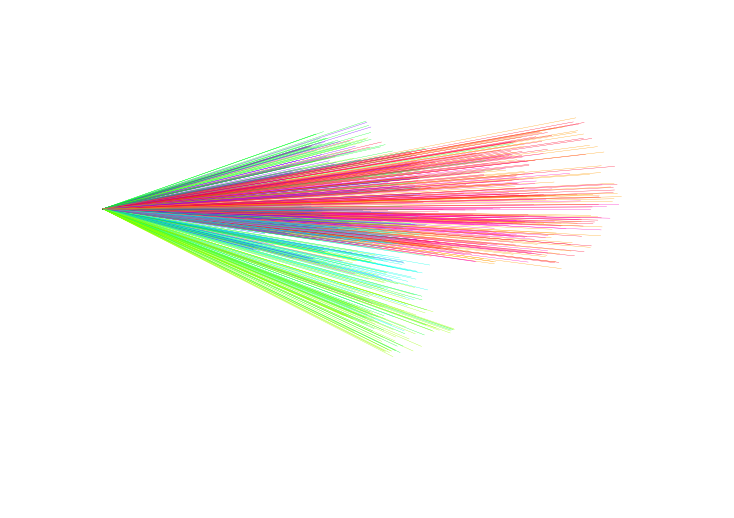

In [23]:
fig = plt.figure(figsize=(10,7), frameon=False)
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0,0,0)

for i in range(X_audio_embedded.shape[0]):
    ax.plot([0, X_audio_embedded[i, 0]], 
            [0, X_audio_embedded[i, 1]],
            zs=[0, X_audio_embedded[i, 2]], 
            color=color_dict[Y_test[i]], 
            linewidth=0.3)
    ax.axis('off')


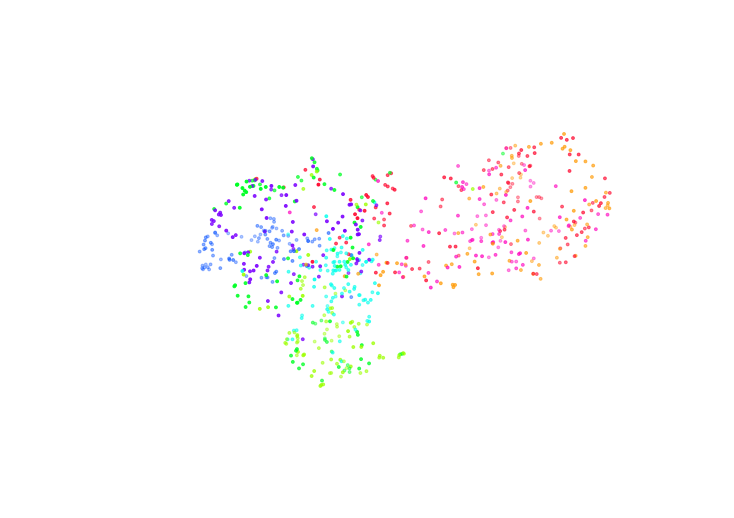

In [24]:
fig = plt.figure(figsize=(10,7), frameon=False)
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0,0,0)

ax.scatter(X_audio_embedded[:, 0], X_audio_embedded[:, 1], X_audio_embedded[:, 2], 
            c=Y_test, cmap='gist_rainbow', s=8)
ax.axis('off')
plt.show()

Well we see some clustering, but it looks a bit messy. Let's now move onto the GAIA-based approach, which will enable us to better visualize the clustering in the latent space.

# Building the GAIA Model

For this application, we'll be exploring a generative adversarial interpolative autoencoder (GAIA) network as detailed in [this paper](https://arxiv.org/pdf/1807.06650.pdf). This architecture entails using an autoencoder (AE) as both the generator and discriminator of a generative adversarial network (GAN).

To proceed, we start by defining the architecture.

In [25]:
class Encoder(tf.keras.Model):

    def __init__(self, latent_dim=LATENT_DIM, dims=DIMS):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.dims = dims

        self.encoder = self.construct_encoder()


    def construct_encoder(self):
        inputs = tf.keras.Input(shape=self.dims)
        x = tf.keras.layers.Conv2D(filters=32, 
                                   kernel_size=3, 
                                   strides=(2, 2), 
                                   activation=tf.nn.leaky_relu)(inputs)
        x = tf.keras.layers.Conv2D(filters=64, 
                                   kernel_size=3, 
                                   strides=(2, 2), 
                                   activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2D(filters=128, 
                                   kernel_size=3, 
                                   strides=(2, 2), 
                                   activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2D(filters=256, 
                                   kernel_size=3, 
                                   strides=(2, 2), 
                                   activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2D(filters=256, 
                                   kernel_size=3, 
                                   strides=(2, 2), 
                                   activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Flatten()(x)
        outputs = tf.keras.layers.Dense(units=self.latent_dim)(x)
        encoder = tf.keras.Model(inputs=inputs, outputs=outputs, name='encoder')
        return encoder

    def call(self, inputs):
        return self.encoder(inputs)
"""
EXAMPLE TESTS:

encoder_example = Encoder(latent_dim=13, dims=(128,128,1))
encoder_example.encoder.summary()
specs_example = spec_builder(X_train[0:1])
encoder_example(specs_example)
"""
print()

Next, we define the decoder.

In [26]:
class Decoder(tf.keras.Model):

    def __init__(self, latent_dim=LATENT_DIM, res=RES):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.res = res

        self.decoder = self.construct_decoder()


    def construct_decoder(self):
        inputs = tf.keras.Input(shape=(self.latent_dim,))
        x = tf.keras.layers.Dense(units=(RES // 32) * (RES // 32) * 256, activation='relu')(inputs)
        x = tf.keras.layers.Reshape(target_shape=((RES // 32), (RES // 32), 256))(x)
        x = tf.keras.layers.Conv2DTranspose(filters=256, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            padding='same', 
                                            activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2DTranspose(filters=256, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            padding='same', 
                                            activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2DTranspose(filters=128, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            padding='same', 
                                            activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2DTranspose(filters=64, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            padding='same', 
                                            activation=tf.nn.leaky_relu)(x)
        x = tf.keras.layers.Conv2DTranspose(filters=32, 
                                            kernel_size=3, 
                                            strides=(2, 2), 
                                            padding='same', 
                                            activation=tf.nn.leaky_relu)(x)
        outputs = tf.keras.layers.Conv2DTranspose(filters=1, 
                                            kernel_size=3, 
                                            strides=(1, 1), 
                                            padding='same', 
                                            activation='sigmoid')(x)
        encoder = tf.keras.Model(inputs=inputs, outputs=outputs)
        return encoder

    def call(self, inputs):
        return self.decoder(inputs)

"""
EXAMPLE TESTS:

decoder_example = Decoder(latent_dim=13)
decoder_example.decoder.summary()
decoder_example(encoder_example(specs_example))
"""
print()

Lastly, we need a UNET for the discriminator:

In [27]:
class UNET(tf.keras.Model):

    def __init__(self, latent_dim=LATENT_DIM, dims=DIMS):
        super(UNET, self).__init__()
        self.latent_dim = latent_dim
        self.dims = dims


        self.unet = self.construct_unet()

    def unet_convblock_down(self, inputs, channels=16):
        x = tf.keras.layers.Conv2D(filters=channels,
                                   kernel_size=(3,3),
                                   activation=tf.nn.leaky_relu,
                                   padding='same',
                                   kernel_initializer='he_normal')(inputs)
        x = tf.keras.layers.Conv2D(filters=channels,
                                   kernel_size=(3,3),
                                   activation=tf.nn.leaky_relu,
                                   padding='same',
                                   kernel_initializer='he_normal')(x)
        pool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
        return x, pool

    def unet_convblock_up(self, last_conv, cross_conv, channels=16):
        up_conv = tf.keras.layers.UpSampling2D(size=(2, 2))(last_conv)
        merge = tf.keras.layers.concatenate([up_conv, cross_conv], axis=3)
        x = tf.keras.layers.Conv2D(filters=channels,
                                   kernel_size=(3,3),
                                   activation=tf.nn.leaky_relu,
                                   padding='same',
                                   kernel_initializer='he_normal')(merge)
        x = tf.keras.layers.Conv2D(filters=channels,
                                   kernel_size=(3,3),
                                   activation=tf.nn.leaky_relu,
                                   padding='same',
                                   kernel_initializer='he_normal')(x)
        return x

    def construct_unet(self):
        inputs = tf.keras.Input(shape=self.dims)
        up_1, pool_1 = self.unet_convblock_down(inputs, channels=16)
        up_2, pool_2 = self.unet_convblock_down(pool_1, channels=32)
        up_3, pool_3 = self.unet_convblock_down(pool_2, channels=64)
        up_4, pool_4 = self.unet_convblock_down(pool_3, channels=128)
        conv_middle = tf.keras.layers.Conv2D(filters=128,
                                             kernel_size=(3, 3), 
                                             activation=tf.nn.leaky_relu, 
                                             kernel_initializer='he_normal',
                                             padding='same')(pool_4)
        conv_middle = tf.keras.layers.Conv2D(filters=128,
                                             kernel_size=(3, 3), 
                                             activation=tf.nn.leaky_relu, 
                                             kernel_initializer='he_normal',
                                             padding='same')(conv_middle)
        down_4 = self.unet_convblock_up(conv_middle, up_4, channels=128)
        down_3 = self.unet_convblock_up(down_4, up_3, channels=64)
        down_2 = self.unet_convblock_up(down_3, up_2, channels=32)
        down_1 = self.unet_convblock_up(down_2, up_1, channels=16)
        outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='tanh')(down_1)
        unet = tf.keras.Model(inputs=inputs, outputs=outputs)
        return unet

    def call(self, x):
        return self.unet(x)

"""
EXAMPLE TESTS:

unet_example = UNET()
unet_example.unet.summary()
unet_example(specs_example)
"""
print()

Now we'll put it all together and construct the GAIA.

In [28]:
class GAIA(tf.keras.Model):

    def __init__(self, d_prop_xg=1.0, g_prop_interp=1.0, **kwargs):
        super(GAIA, self).__init__()
        self.__dict__.update(kwargs)
        self.d_prop_xg = d_prop_xg
        self.g_prop_interp = g_prop_interp

        self.encoder = Encoder(self.latent_dim, self.dims)
        self.decoder = Decoder(self.latent_dim, self.res)

        self.discriminator = UNET(self.latent_dim, self.dims)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def discriminate(self, x):
        return self.discriminator(x)

    def regularization(self, x1, x2):
        return tf.reduce_mean(tf.square(x1 - x2))

    def _interpolate_z(self, z):
        if self.chsq.df != z.shape[0]:
            self.chsq = Chi2(df=1 / z.shape[0])
        ip = self.chsq.sample((z.shape[0], z.shape[0]))
        ip = ip / tf.reduce_sum(ip, axis=0)
        zi = tf.transpose(tf.tensordot(tf.transpose(z), ip, axes=1))
        return zi

    def network_pass(self, x):
        z = self.encode(x)
        xg = self.decode(z)
        zi = self._interpolate_z(z)
        xi = self.decode(zi)
        d_xi = self.discriminate(xi)
        d_x = self.discriminate(x)
        d_xg = self.discriminate(xg)
        return z, xg, zi, xi, d_xi, d_x, d_xg

    def compute_loss(self, x):
        z, xg, zi, xi, d_xi, d_x, d_xg = self.network_pass(x)

        X_G_X_loss = tf.clip_by_value(self.regularization(x, xg), 0, 1)
        D_X_D_G_X_loss = tf.clip_by_value(self.regularization(d_x, d_xg), 0, 1)
        X_D_G_X_loss = tf.clip_by_value(self.regularization(x, d_xg), 0, 1)
        X_D_X_G_X_loss = tf.clip_by_value(self.regularization(xg, d_xg), 0, 1)
        X_D_G_Zi_loss = tf.clip_by_value(self.regularization(xi, d_xi), 0, 1)
        X_G_loss = (X_D_G_Zi_loss + X_D_G_X_loss) / 2.0
        X_D_X_loss = tf.clip_by_value(self.regularization(x, d_x), 0, 1)

        D_loss = (X_D_X_loss + X_D_G_X_loss - tf.clip_by_value(X_D_G_Zi_loss, 0, X_D_X_loss) * self.d_prop_xg)

        G_loss = (X_G_X_loss + tf.clip_by_value(X_D_G_Zi_loss, 0, X_D_X_loss) * self.g_prop_interp)

        return (X_D_G_X_loss,
                X_D_G_Zi_loss,
                X_G_loss,
                X_D_X_loss,
                X_D_X_G_X_loss,
                X_G_X_loss,
                G_loss,
                D_loss)

    def compute_gradients(self, x):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            _, _, _, _, _, _, G_loss, D_loss = self.compute_loss(x)

            gen_loss = G_loss
            disc_loss = D_loss

        gen_gradients = gen_tape.gradient(gen_loss, 
                                          self.encoder.trainable_variables + self.decoder.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):
        self.g_optimizer.apply_gradients(zip(gen_gradients, 
                                               self.encoder.trainable_variables + self.decoder.trainable_variables))
        self.d_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

    def train(self, x):
        gen_gradients, disc_gradients = self.compute_gradients(x)
        self.apply_gradients(gen_gradients, disc_gradients)

def sigmoid(x, shift=0.0, mult=20):
    sigma = tf.constant(1.0) / (tf.constant(1.0) + tf.exp(-tf.constant(1.0) * ((x + tf.constant(shift)) * mult)))
    return sigma

"""
EXAMPLE TESTS

G_OPTIMIZER = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
D_OPTIMIZER = tf.keras.optimizers.RMSprop(1e-3)

gaia_example = GAIA(latent_dim=LATENT_DIM, 
                    dims=(RES,RES,1), 
                    res=RES, 
                    chsq=Chi2(df=1 / BATCH_SIZE),
                    g_optimizer=G_OPTIMIZER,
                    d_optimizer=D_OPTIMIZER)

example_encoded = gaia_example.encoder(specs_example)
example_decoded = gaia_example.decoder(example_encoded)
discriminated = gaia_example.discriminator(specs_example)
print(example_encoded, example_decoded, discriminated)
print(gaia_example.encode(specs_example))
print(gaia_example.decode(example_encoded))
print(gaia_example.discriminate(specs_example))
print(gaia_example._interpolate_z(example_encoded))
print('\n', 'NETWORK PASS')
print(gaia_example.network_pass(specs_example))
print(gaia_example.compute_loss(specs_example))
gg, dg = gaia_example.compute_gradients(specs_example)
print(gg, dg)
gaia_example.apply_gradients(gg, dg)
gaia_example.train(specs_example)
"""
print()

Great! Now it's time to instantiate a GAIA model and begin training.

# Training the GAIA

In [29]:
G_OPTIMIZER = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
D_OPTIMIZER = tf.keras.optimizers.RMSprop(1e-4)

gaia_model = GAIA(latent_dim=LATENT_DIM,
                  res=RES,
                  dims=DIMS,
                  g_optimizer=G_OPTIMIZER,
                  d_optimizer=D_OPTIMIZER,
                  chsq = Chi2(df=1 / BATCH_SIZE),
                  d_prop_xg = D_PROP_XG,
                  g_prop_interp = G_PROP_INTERP)

In [30]:
def visualize_reconstructions(model, example_data, epoch, step, save=True):
    z, xg, zi, xi, d_xi, d_x, d_xg = model.network_pass(example_data)
    
    fig, axes = plt.subplots(4,4,figsize=(8,8))
    axs = axes.flatten()
    axs[0].set_title('Data')
    axs[1].set_title('Reconstruction')
    axs[2].set_title('Data')
    axs[3].set_title('Reconstruction')
    for i in range(8):
        axs[2*i].imshow(example_data[i, :, :, 0].numpy(), cmap='magma', vmin=0, vmax=1)
        axs[2*i].invert_yaxis()
        axs[2*i].axis('off')
            
        axs[2*i+1].imshow(xg[i, :, :, 0].numpy(), cmap='magma', vmin=0, vmax=1)
        axs[2*i+1].invert_yaxis()
        axs[2*i+1].axis('off')
    
    if save:
        plt.savefig('Macaque_Figs/image_at_epoch_{:04d}_step_{:04d}.png'.format(epoch, step))
    plt.show()

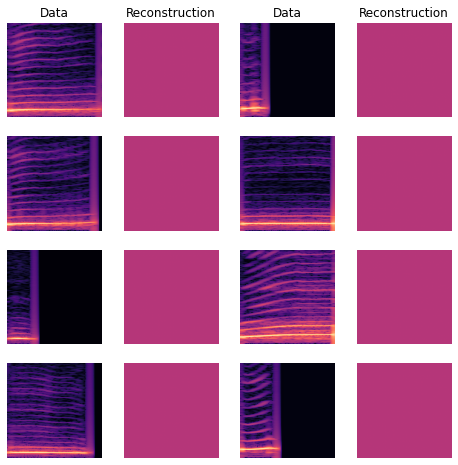

In [31]:
original_specs = spec_builder(example_data)
visualize_reconstructions(gaia_model, original_specs, 999, 999, save=False)

In [32]:
losses = pd.DataFrame(columns = ['D_Loss', 'G_Loss'])
losses.head()

Empty DataFrame
Columns: [D_Loss, G_Loss]
Index: []

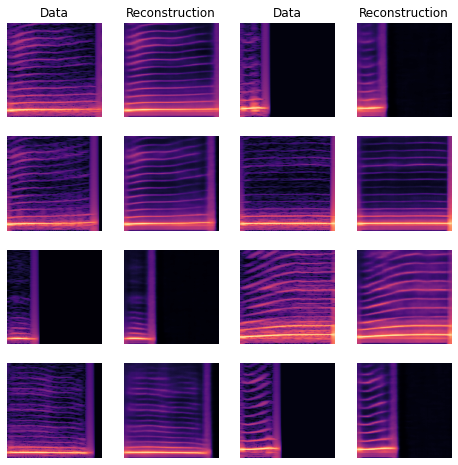

100%|██████████| 187/187 [05:39<00:00,  1.82s/it]

Epoch: 49
>>>>> D Loss: 0.0019183611337912274 -------- G Loss: 0.001642247336358828


In [33]:
n_epochs = 50
for epoch in range(n_epochs):
    running_d_loss = 0
    running_g_loss = 0
    for batch, train_x in tqdm.tqdm(zip(range(N_TRAIN_BATCHES), gaia_train_ds), total=N_TRAIN_BATCHES):
        train_x_specs = spec_builder(train_x)
        gaia_model.train(train_x_specs)
        
        _, _, _, _, _, _, d_loss, g_loss = gaia_model.compute_loss(train_x_specs)
        running_d_loss += d_loss.numpy()
        running_g_loss += g_loss.numpy()
        
        display.clear_output(wait=True)
        visualize_reconstructions(gaia_model, original_specs, epoch, batch, save=False)
    D_loss = running_d_loss / N_TRAIN_BATCHES
    G_loss = running_g_loss / N_TRAIN_BATCHES
    loss_dict = {'D_Loss':D_loss, 'G_Loss':G_loss}
    losses = losses.append(loss_dict, ignore_index=True)
    print('Epoch: {}'.format(epoch))
    print('>>>>> D Loss: {} -------- G Loss: {}'.format(D_loss, G_loss))

In [34]:
gaia_trained_encoder = gaia_model.encoder
gaia_trained_encoder.save('07_GAIA/GAIAEncoder')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 07_GAIA/GAIAEncoder/assets


In [35]:
losses.to_csv('07_GAIA/GAIA_Losses.csv', index=True)

After training and saving the model and the losses, it's nice to be able to visualize the reconstruction. Below is an animation of the model learning to reconstruct data.

In [1]:
from IPython.display import Video

Video('07_Animations/MacaqueGAIA.mp4')

## Using the Trained GAIA

### Visualizing High-Dimensional Spaces with PCA, tSNE, and UMAP

Now that we have a trained GAIA, we'll extract the encoder in order to compress the original raw audio inputs into the 128-dimensional latent space. Then, we'll carry out an example downstream task using these deep-learned latent space vectors.

We'll start off by using a number of unsupervised dimensionality reduction algorithms (PCA, tSNE, UMAP) in order to visualize the latent space representation.

In [36]:
X_test_specs = spec_builder(X_test)
encoded_vecs = gaia_model.encode(X_test_specs)

In [37]:
encoded_vecs_np = encoded_vecs.numpy()
encoded_vecs_np.shape

(749, 128)

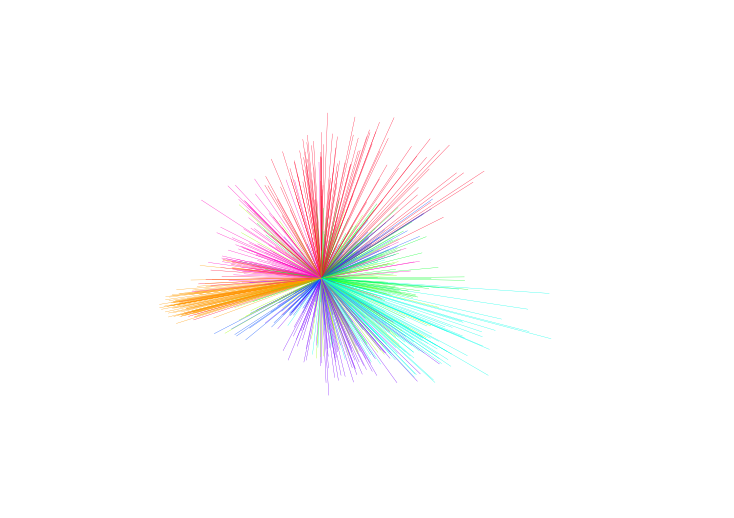

In [38]:
X = encoded_vecs_np
Y = Y_test
pca = PCA(n_components=3)
pca.fit(X)
X_embedded = pca.transform(X)

fig = plt.figure(figsize=(10,7), frameon=False)
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0,0,0)

for i in range(X_embedded.shape[0]):
    ax.plot([0, X_embedded[i, 0]], [0, X_embedded[i, 1]],zs=[0, X_embedded[i, 2]], color=color_dict[Y[i]], linewidth=0.3)
    ax.axis('off')

In [2]:
Video('07_Animations/MacaqueLatentSpacePCA.mp4')

In [39]:
X = encoded_vecs_np
Y = Y_test
X_embedded = TSNE(n_components=3, perplexity=30, init='pca', learning_rate=200, verbose=2, n_iter=5000).fit_transform(X)
X_embedded = np.delete(X_embedded, np.argmax(X_embedded, axis=0)[0], 0)
Y = np.delete(Y, np.argmax(X_embedded, axis=0)[0], 0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 749 samples in 0.027s...
[t-SNE] Computed neighbors for 749 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 749 / 749
[t-SNE] Mean sigma: 6.379043
[t-SNE] Computed conditional probabilities in 0.054s
[t-SNE] Iteration 50: error = 52.1100693, gradient norm = 0.1946114 (50 iterations in 1.070s)
[t-SNE] Iteration 100: error = 53.7864113, gradient norm = 0.1750548 (50 iterations in 0.915s)
[t-SNE] Iteration 150: error = 55.6413803, gradient norm = 0.1653983 (50 iterations in 0.922s)
[t-SNE] Iteration 200: error = 56.1582260, gradient norm = 0.1835730 (50 iterations in 0.873s)
[t-SNE] Iteration 250: error = 56.5228844, gradient norm = 0.1677406 (50 iterations in 0.892s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.522884
[t-SNE] Iteration 300: error = 0.7909465, gradient norm = 0.0005742 (50 iterations in 1.138s)
[t-SNE] Iteration 350: error = 0.7073022, gradient norm = 0.0003677 (

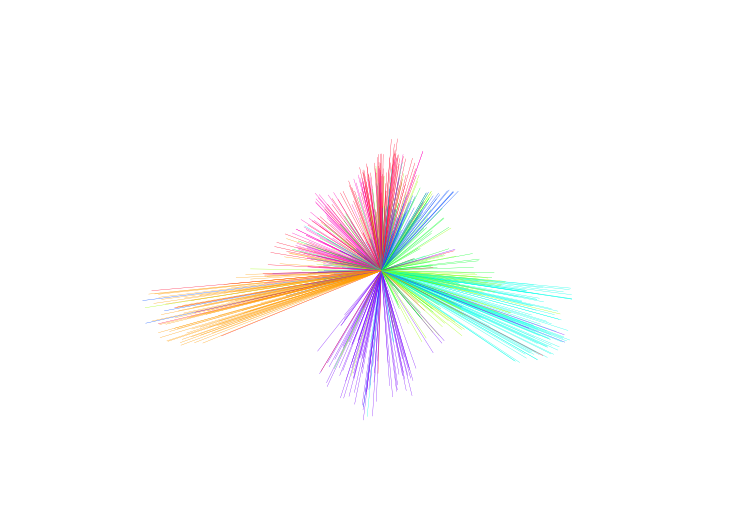

In [40]:
fig = plt.figure(figsize=(10,7), frameon=False)
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0,0,0)

for i in range(X_embedded.shape[0]):
    ax.plot([0, X_embedded[i, 0]], [0, X_embedded[i, 1]],zs=[0, X_embedded[i, 2]], color=color_dict[Y[i]], linewidth=0.3)
    ax.axis('off')

In [3]:
Video('07_Animations/MacaqueLatentSpaceTSNE.mp4')

In [41]:
reducer=UMAP(random_state=42, n_components=3)
reducer.fit(X)
X_embedded = reducer.transform(X)
Y = Y_test

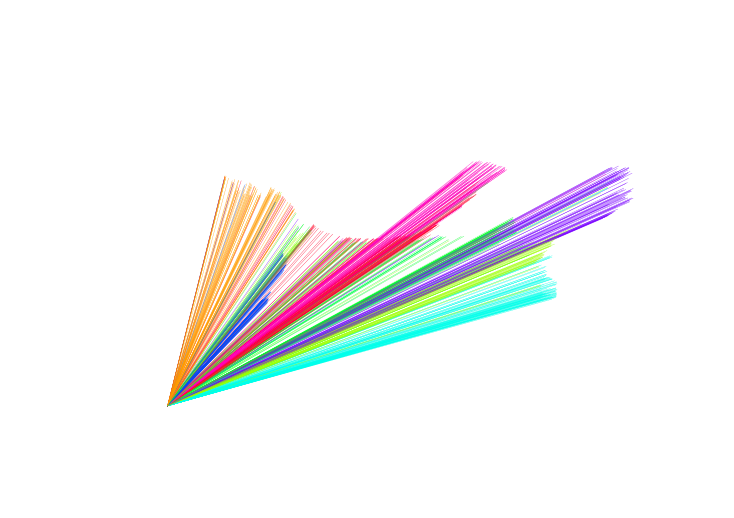

In [42]:
fig = plt.figure(figsize=(10,7), frameon=False)
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0,0,0)

for i in range(X_embedded.shape[0]):
    ax.plot([0, X_embedded[i, 0]], [0, X_embedded[i, 1]],zs=[0, X_embedded[i, 2]], color=color_dict[Y[i]], linewidth=0.3)
    ax.axis('off')

In [4]:
Video('07_Animations/MacaqueLatentSpaceUMAP.mp4')

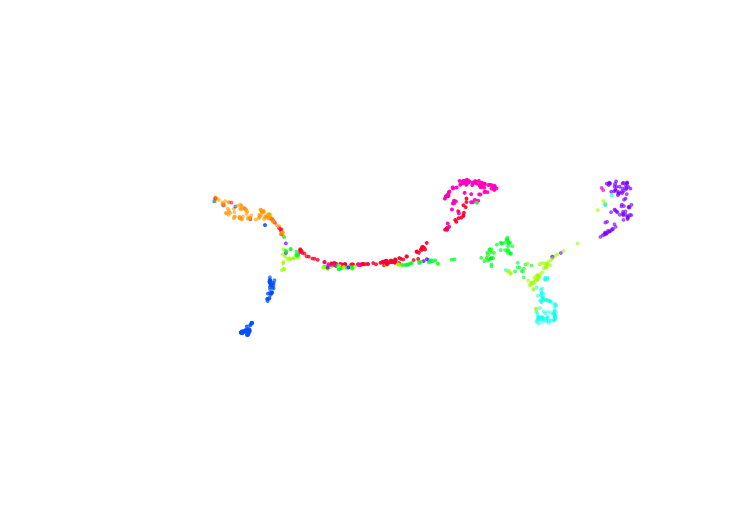

In [43]:
fig = plt.figure(figsize=(10,7), frameon=False)
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0,0,0)

ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
            c=Y_test, cmap='gist_rainbow', s=8)
ax.axis('off')
plt.show()

In [5]:
Video('07_Animations/MacaqueLatentSpaceUMAP3D.mp4')

The above figures and animations clearly demonstrate one of the advantages of implementing these deep-learned latent space-based representations. We are able to see denser clustering of the data, which suggests that we might be able to employ less-complex models to fit the data. We'll explore this below.

### Using the Latent Space Representation for Downstream Classification Tasks

Now that we have our encoded 128-dimensional latent space vectors, let's train a simple ConvNet to carry out the classification according to the identity of the caller.

In [44]:
X_train_encoded_vecs = encoded_vecs_np.reshape(-1, 16, 8, 1)
Y_train_encoded_vecs = Y_test
X_train_encoded_vecs.shape, Y_train_encoded_vecs.shape

((749, 16, 8, 1), (749,))

In [45]:
classifier_model = tf.keras.models.Sequential()
classifier_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(16,8,1)))
classifier_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
classifier_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
classifier_model.add(tf.keras.layers.Dropout(0.25))
classifier_model.add(tf.keras.layers.Flatten())
classifier_model.add(tf.keras.layers.Dense(128, activation='relu'))
classifier_model.add(tf.keras.layers.Dropout(0.5))
classifier_model.add(tf.keras.layers.Dense(8, activation='softmax'))

classifier_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

classifier_model.fit(X_train_encoded_vecs, Y_train_encoded_vecs,
          batch_size=32,
          epochs=25,
          verbose=1,
          validation_split=0.1)

Epoch 1/25
22/22 [==============================] - 0s 15ms/step - loss: 1.8173 - accuracy: 0.3442 - val_loss: 1.2043 - val_accuracy: 0.7733
Epoch 2/25
22/22 [==============================] - 0s 6ms/step - loss: 1.1081 - accuracy: 0.6662 - val_loss: 0.6271 - val_accuracy: 0.8133
Epoch 3/25
22/22 [==============================] - 0s 6ms/step - loss: 0.6773 - accuracy: 0.8116 - val_loss: 0.3973 - val_accuracy: 0.8667
Epoch 4/25
22/22 [==============================] - 0s 6ms/step - loss: 0.5398 - accuracy: 0.8487 - val_loss: 0.2930 - val_accuracy: 0.8933
Epoch 5/25
22/22 [==============================] - 0s 6ms/step - loss: 0.3767 - accuracy: 0.9021 - val_loss: 0.2248 - val_accuracy: 0.9200
Epoch 6/25
22/22 [==============================] - 0s 6ms/step - loss: 0.2888 - accuracy: 0.9214 - val_loss: 0.2316 - val_accuracy: 0.9200
Epoch 7/25
22/22 [==============================] - 0s 6ms/step - loss: 0.2866 - accuracy: 0.9184 - val_loss: 0.1773 - val_accuracy: 0.9333
Epoch 8/25
22/22 [=

Wow! That's a neat result! Let's try one other approach involving a more complex graph topology. We'll use multi-headed dual input CNN in which we provide as inputs both the spectrogram and latent space representations.

In [46]:
X_raw = X_test
X_train_encoded = X_train_encoded_vecs
X_train_raw = X_raw
Y_train = Y
X_train_encoded.shape, X_train_raw.shape, Y_train.shape

((749, 16, 8, 1), (749, 8549), (749,))

In [47]:
raw_input = tf.keras.Input(shape=(WINDOW_WIDTH,))
encoded_input = tf.keras.Input(shape=(16,8,1))

x_r = SpecGram()(raw_input)
x_r = MinMaxScaler()(x_r)
x_r = tf.keras.layers.Reshape((RES, RES, 1), input_shape=(RES, RES))(x_r)
x_r = tf.keras.layers.Conv2D(filters=32, 
                             kernel_size=(3, 3),
                             activation='relu',
                             input_shape=(RES,RES,1))(x_r)
x_r = tf.keras.layers.Conv2D(filters=64, 
                             kernel_size=(3, 3), 
                             activation='relu')(x_r)
x_r = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_r)
x_r = tf.keras.layers.Dropout(0.25)(x_r)
x_r = tf.keras.layers.Flatten()(x_r)
x_r = tf.keras.layers.Dense(128, activation='relu')(x_r)
x_r = tf.keras.layers.Dropout(0.5)(x_r)
#x_r = tf.keras.layers.Dense(8, activation='softmax')(x_r)


x_e = tf.keras.layers.Conv2D(filters=32, 
                             kernel_size=(3, 3),
                             activation='relu',
                             input_shape=(11,11,1))(encoded_input)
x_e = tf.keras.layers.Conv2D(filters=64, 
                             kernel_size=(3, 3), 
                             activation='relu')(x_e)
x_e = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_e)
x_e = tf.keras.layers.Dropout(0.25)(x_e)
x_e = tf.keras.layers.Flatten()(x_e)
x_e = tf.keras.layers.Dense(128, activation='relu')(x_e)
x_e = tf.keras.layers.Dropout(0.5)(x_r)
#x_e = tf.keras.layers.Dense(8, activation='softmax')(x_e)

x = tf.keras.layers.concatenate([x_r, x_e])
output = tf.keras.layers.Dense(8, activation='softmax')(x)

dual_classifier = tf.keras.Model(inputs=[raw_input, encoded_input], outputs=output)

dual_classifier.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

dual_classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 8549)]       0                                            
__________________________________________________________________________________________________
spectrogram (SpecGram)          (None, 128, 128)     0           input_6[0][0]                    
__________________________________________________________________________________________________
min_max_scaler (MinMaxScaler)   (None, 128, 128)     0           spectrogram[0][0]                
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 128, 128, 1)  0           min_max_scaler[0][0]             
____________________________________________________________________________________________

In [48]:
dual_classifier.fit([X_train_raw, X_train_encoded], Y_train,
          batch_size=32,
          epochs=15,
          verbose=1,
          validation_split=0.1)

Epoch 1/15
22/22 [==============================] - 14s 616ms/step - loss: 2.7578 - accuracy: 0.2181 - val_loss: 1.6549 - val_accuracy: 0.4667
Epoch 2/15
22/22 [==============================] - 13s 591ms/step - loss: 1.5968 - accuracy: 0.4184 - val_loss: 1.1289 - val_accuracy: 0.6667
Epoch 3/15
22/22 [==============================] - 13s 589ms/step - loss: 1.2286 - accuracy: 0.5831 - val_loss: 0.7795 - val_accuracy: 0.7733
Epoch 4/15
22/22 [==============================] - 13s 602ms/step - loss: 1.0417 - accuracy: 0.6246 - val_loss: 0.5754 - val_accuracy: 0.8400
Epoch 5/15
22/22 [==============================] - 13s 608ms/step - loss: 0.8693 - accuracy: 0.6958 - val_loss: 0.3819 - val_accuracy: 0.8800
Epoch 6/15
22/22 [==============================] - 13s 605ms/step - loss: 0.6281 - accuracy: 0.7819 - val_loss: 0.2537 - val_accuracy: 0.9200
Epoch 7/15
22/22 [==============================] - 13s 590ms/step - loss: 0.5042 - accuracy: 0.8249 - val_loss: 0.2102 - val_accuracy: 0.9200

### Visualizing High-Dimensional Data

Here, we'll explore a couple additional techniques for visualizing high-dimensional data. These include [Andrews curves](https://pandas.pydata.org/docs/reference/api/pandas.plotting.andrews_curves.html) and [parallel coordinates](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.parallel_coordinates.html), as well as PCA and UMAP.

In [25]:
loaded_encoder = tf.keras.models.load_model('07_GAIA/GAIAEncoder')

In [28]:
with tf.device('/CPU:0'):    
    X_specs = spec_builder(X_test)
    X_encoded = loaded_encoder(X_specs)
    X_encoded_np = X_encoded.numpy()
    Y_encoded = Y_test

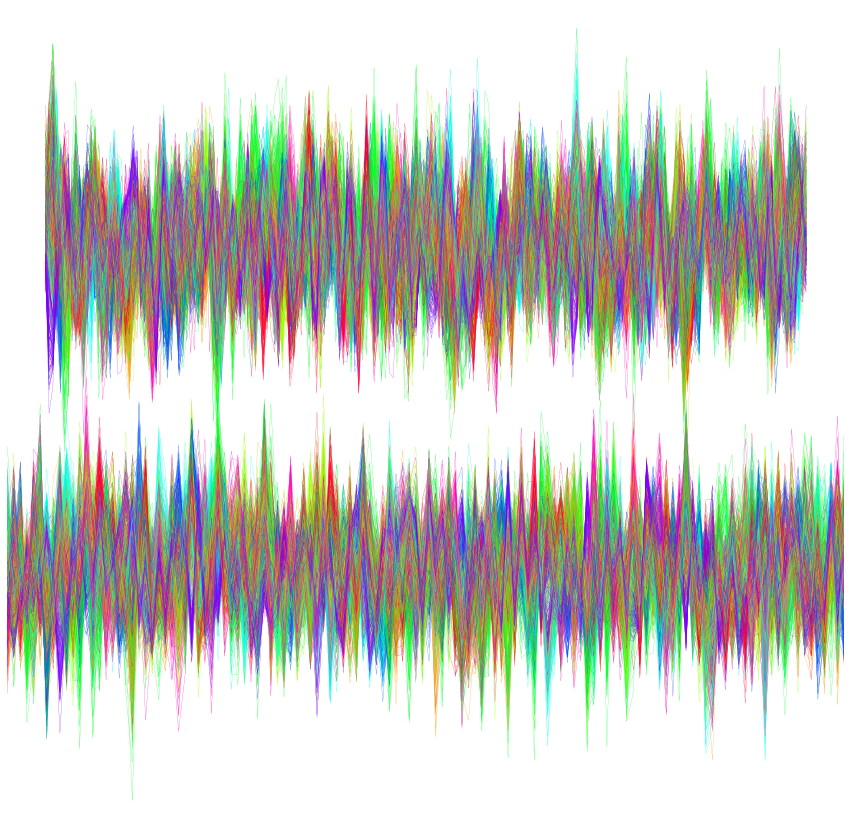

In [42]:
encoded_df = pd.DataFrame(X_encoded_np)
encoded_df['Class'] =  pd.Series(Y_encoded)

fig, axes = plt.subplots(2,1, figsize=(15,15))
fig.subplots_adjust(wspace=0, hspace=-0.25)

pd.plotting.andrews_curves(encoded_df, 'Class', 
                           colormap='gist_rainbow', 
                           linewidth=0.2, 
                           ax=axes[0])
axes[0].axis('off')
axes[0].get_legend().remove()

pd.plotting.parallel_coordinates(encoded_df, 'Class', 
                                 colormap='gist_rainbow', 
                                 linewidth=0.2, 
                                 axvlines=False, 
                                 ax=axes[1])
axes[1].axis('off')
axes[1].get_legend().remove()
plt.show()

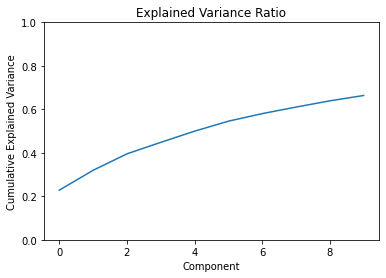

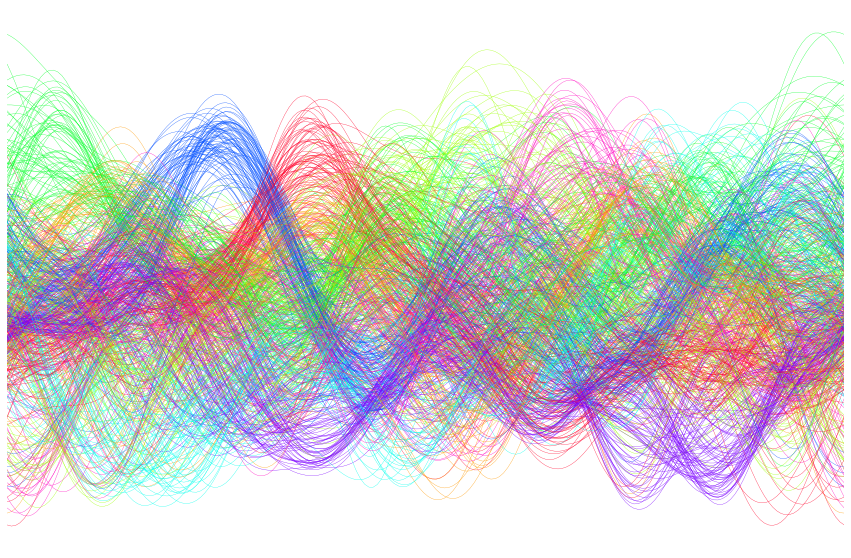

In [65]:
def visualize_reduced_vecs(X, Y, pca_components, umap_components=None, pca_var_vis=False, **kwargs):

    assert pca_components <= X.shape[1], 'PCA components greater than latent space dimensionality'
    
    if umap_components is not None:
        assert umap_components <= X.shape[1], 'UMAP components greater than latent space dimensionality'
        assert umap_components >= pca_components, 'UMAP components less than PCA components'
        
        umap_reducer = UMAP(n_components=umap_components, random_state=42)
        umap_reducer.fit(X)
        X = umap_reducer.transform(X)
    
    pca = PCA(n_components=pca_components)
    pca.fit(X)
    if pca_var_vis:
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.ylim([0, 1])
        plt.title('Explained Variance Ratio')
        plt.ylabel('Cumulative Explained Variance')
        plt.xlabel('Component')
        plt.show()
    X_embedded = pca.transform(X)
    
    embedded_df = pd.DataFrame(X_embedded)
    embedded_df['Class'] =  pd.Series(Y)
    
    plt.figure(figsize=(15,10))
    pd.plotting.andrews_curves(embedded_df, 'Class', colormap='gist_rainbow', linewidth=0.3)
    plt.axis('off')
    plt.gca().get_legend().remove()
    plt.show()
    
visualize_reduced_vecs(X_encoded, Y_encoded, 10, pca_var_vis=True)

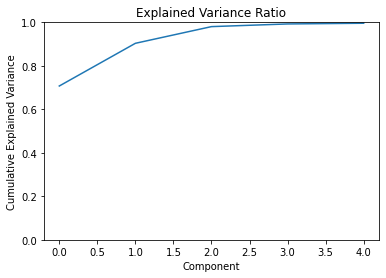

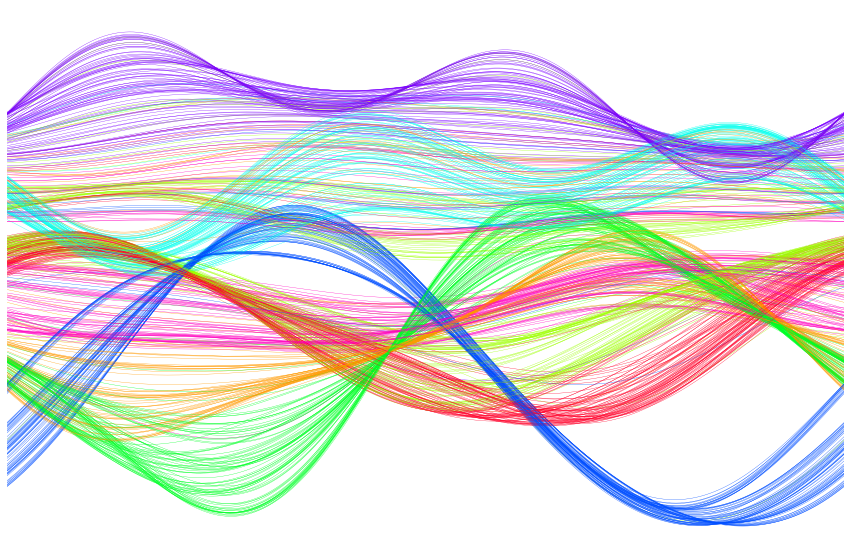

In [70]:
visualize_reduced_vecs(X_encoded, Y_encoded, 5, umap_components=10, pca_var_vis=True)

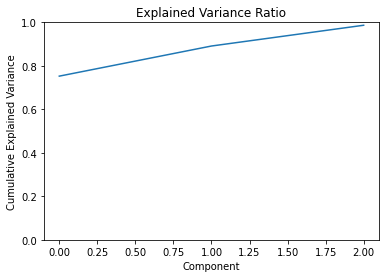

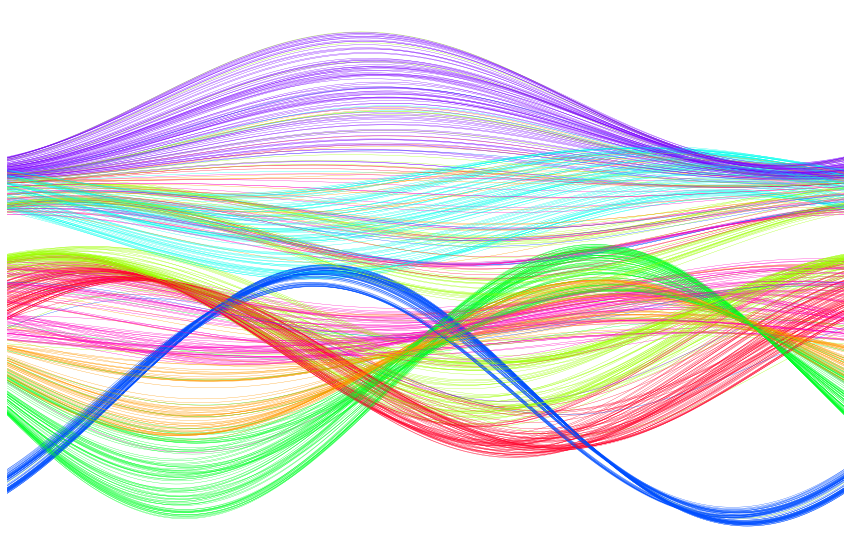

In [71]:
visualize_reduced_vecs(X_encoded, Y_encoded, 3, umap_components=5, pca_var_vis=True)

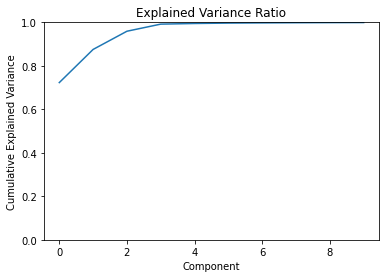

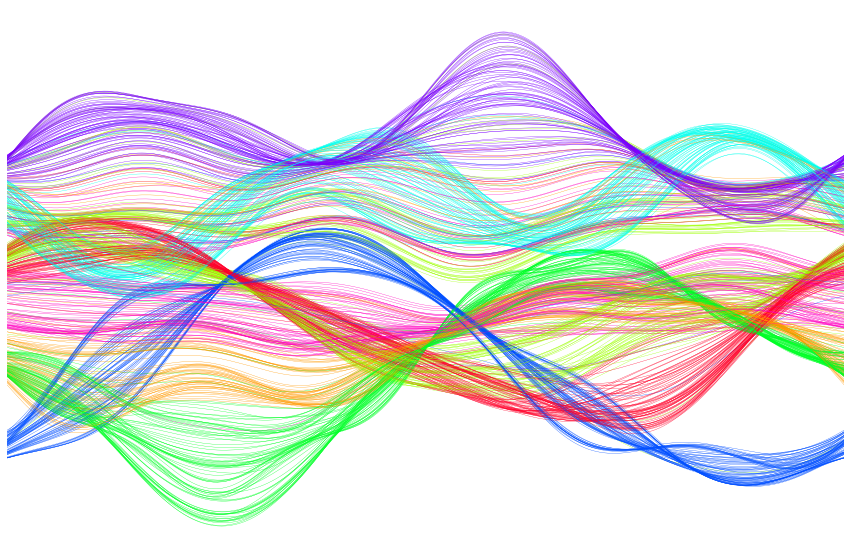

In [74]:
visualize_reduced_vecs(X_encoded, Y_encoded, 10, umap_components=64, pca_var_vis=True)

### Classifying Data with Simple Models

As a final experiment, we'll use a couple of simple classifiers (k-nearest neighbors classifier and random forest classifier) in order to fit the input data. We'll also plot the data in two dimensions along with the classifier decision boundaries.

In [150]:
def decision_boundaries(X, Y, classifier, res=0.15, pad=0.1):
    x0min, x1min = np.min(X, axis=0)
    x0max, x1max = np.max(X, axis=0)
    
    x0grid, x1grid=np.meshgrid(np.arange(x0min-pad, x0max+pad, res),
                             np.arange(x1min-pad, x1max+pad, res))
    points = np.array([x0grid.ravel(), x1grid.ravel()]).T
    num_points = points.shape[0]
    
    zf = []
    for idx in range(num_points):
        if idx % 1000 == 0:
            print(idx, 'out of', num_points)
        point = points[idx, :].reshape(1,-1)
        pred = classifier.predict(point)
        zf.append(np.round(pred))
    zf = np.array(zf)
    zf = zf.reshape(xgrid.shape)
    
    fig = plt.figure(figsize=(7,7))
    plt.contourf(x0grid, x1grid, zf, cmap='gist_rainbow', alpha=0.2)
    plt.scatter(X[:,0], X[:,1], c=Y, cmap='gist_rainbow', s=8)
    plt.xlabel('Axis 1')
    plt.ylabel('Axis 2')
    plt.title('Classifier Decision Boundaries')
    plt.show()

In [147]:
umap_red = UMAP(n_components=2, random_state=42)
umap_red.fit(X_encoded)
X_2D = umap_red.transform(X_encoded)

In [148]:
knn2D = KNeighborsClassifier(n_neighbors=2)
knn2D.fit(X_2D, Y_encoded)
knn2D.score(X_2D, Y_encoded)

0.9399198931909212

0 out of 16166
1000 out of 16166
2000 out of 16166
3000 out of 16166
4000 out of 16166
5000 out of 16166
6000 out of 16166
7000 out of 16166
8000 out of 16166
9000 out of 16166
10000 out of 16166
11000 out of 16166
12000 out of 16166
13000 out of 16166
14000 out of 16166
15000 out of 16166
16000 out of 16166


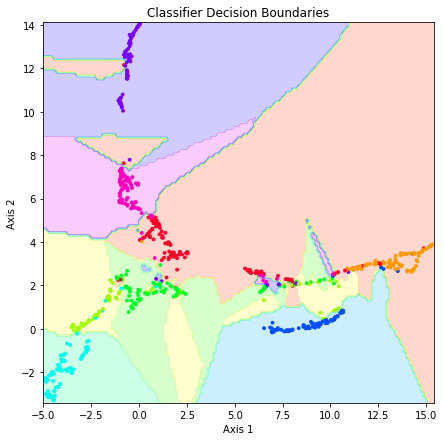

In [151]:
decision_boundaries(X_2D, Y_encoded, knn2D)

In [156]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=42)
rf.fit(X_2D, Y_encoded)
rf.score(X_2D, Y_encoded)

0.8678237650200267

0 out of 16166
1000 out of 16166
2000 out of 16166
3000 out of 16166
4000 out of 16166
5000 out of 16166
6000 out of 16166
7000 out of 16166
8000 out of 16166
9000 out of 16166
10000 out of 16166
11000 out of 16166
12000 out of 16166
13000 out of 16166
14000 out of 16166
15000 out of 16166
16000 out of 16166


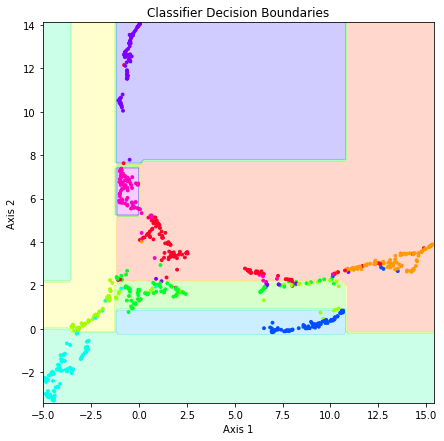

In [157]:
decision_boundaries(X_2D, Y_encoded, rf)

This concludes our discussion of deep-learned representations for machine-learning-based bioacoustics classification tasks.